In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
import numpy as np
np.set_printoptions(suppress=True)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Any, Union

In [2]:
IN_CSV_DATA = Path().cwd().parent.parent / "data/4_data_split"
OUT_MODEL_DATA = Path().cwd().parent.parent / "data/5_models"

# 1. Load in Training and Test Datasets

In [3]:
df_train = pd.read_csv(IN_CSV_DATA/'prepared_train.csv')
df_test = pd.read_csv(IN_CSV_DATA/'prepared_test.csv')

In [4]:
numerical_feature_cols = ['total_distance_mi','total_weight_lbs','avg_cruising_speed', 'log_hours_since_last_ride',
                            'active_time_ratio', 'avg_climb_rate', 'distance_training_intensity','prior_training_load']
categorical_feature_cols = []#['year']
feature_cols = numerical_feature_cols + categorical_feature_cols

target_cols = ['best_power_4s', 'best_power_5s',
                'best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                'best_power_40m', 'best_power_1h', 'best_power_2h']

In [5]:
X_train, y_train = df_train[feature_cols].values, df_train[target_cols].values
X_test, y_test = df_test[feature_cols].values, df_test[target_cols].values

In [6]:
from sklearn.model_selection import cross_val_score, cross_val_predict, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, root_mean_squared_log_error
from sklearn.linear_model import LinearRegression

In [7]:
def timeseries_cross_validated_regression(X, y, regressor, n_subseries_splits=5, verbose:bool=True):
    tss = TimeSeriesSplit(n_splits=n_subseries_splits)
    
    r2_scores = []
    rmsle_scores = []
    predictions = []
    actuals = []
    for train_index, val_index in tss.split(X, y):
        X_tr, X_val = X[train_index], X[val_index]
        y_tr, y_val = y[train_index], y[val_index]
        
        regressor.fit(X_tr, y_tr)
        
        y_pred = regressor.predict(X_val)
        # Ensure all predicted powers are non-negative
        y_pred[y_pred<0] = 0.0
        r2 = r2_score(y_val, y_pred, multioutput='raw_values')
        r2 = np.mean(r2)
        r2_scores.append(r2)
        # NOTE: RMSLE is chosen because it represents the average ratio error between the predicted and the true values.
        #       |--> This is useful because the RMSE error in the 5second effort duration is at a different power scale (kW) than a 20minute effort (Watts)
        # ref: https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a 
        # NOTE: RMSLE is biased in how it penalizes errors. It penalizes UNDERestimation more than OVERestimation
        # This means if we use y_true=y_val as it truly should match, we're okay with overestimating our power curves...
        # So we swap the ordering of these so that we're okay underestimating our power curves. We'd rather be conservative on our estimates of fitness
        rmsle = root_mean_squared_log_error(y_true=y_pred, y_pred=y_val, multioutput='raw_values')
        rmsle = np.mean(rmsle)
        rmsle_scores.append(rmsle)

        predictions.append(y_pred)
        actuals.append(y_val)
        
    if verbose:
        print(f'For metric "R^2", the latest value (final subseries) = {r2_scores[-1]}')
        print(f'For metric "RMSLE", the latest value (final subseries) = {rmsle_scores[-1]}')

    return {'actuals':actuals, 'predictions':predictions, 
            'raw_final_r2':r2_score(actuals[-1], predictions[-1], multioutput='raw_values'),
            'raw_final_rmsle':root_mean_squared_log_error(actuals[-1], predictions[-1], multioutput='raw_values')}

# 1a. Baseline Models: Y=BX+eps, predicting the output matrix.

For each sample $x$, the regressor will predict a vector output of size 17x1

In [8]:
linreg = LinearRegression()

In [9]:
outputs = timeseries_cross_validated_regression(X_train, y_train, linreg, n_subseries_splits=10)

For metric "R^2", the latest value (final subseries) = 0.38669458416810815
For metric "RMSLE", the latest value (final subseries) = 0.7020580801205452


In [10]:
y_pred = outputs['predictions'][-1]
y_val = outputs['actuals'][-1]

In [11]:
final_r2 = outputs['raw_final_r2']
final_rmsle = outputs['raw_final_rmsle']

In [12]:
print(final_r2)

[0.4152137  0.42005859 0.44776513 0.38018739 0.23693144 0.40409512
 0.45159128 0.35952927 0.31296219 0.22499696 0.20633455 0.44100117
 0.40819685 0.44258042 0.34732681 0.45616734 0.61886972]


In [13]:
print(final_rmsle)

[0.22225557 0.22063923 0.21468675 0.22257927 0.22314163 0.20395144
 0.17473641 0.1730554  0.16738854 0.1757151  0.18733261 0.80832363
 0.65323987 1.83285113 1.89367614 2.75589102 1.80552362]


In [14]:
def plot_residuals(y_pred, y_true, column_names:list[str]):
    residual_error = y_true - y_pred
    fig, axes = plt.subplots(3,6, figsize=(16,6), sharex=True, sharey=True)
    columns = np.array(column_names+['none']).reshape(axes.shape)

    for row_i in range(axes.shape[0]):
        for col_j in range(axes.shape[1]):
            ax = axes[row_i, col_j]
            effort_index = (col_j) + (row_i)*(axes.shape[1])
            if effort_index+1 > len(column_names): continue # skip the last, 18ths box
            data = residual_error[:, effort_index]
            _ = ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
            _ = sns.scatterplot(data, ax=ax, alpha=0.75)
            _ = ax.set_title(columns[row_i, col_j])
            _ = ax.grid()
            _ = ax.set_axisbelow(True)

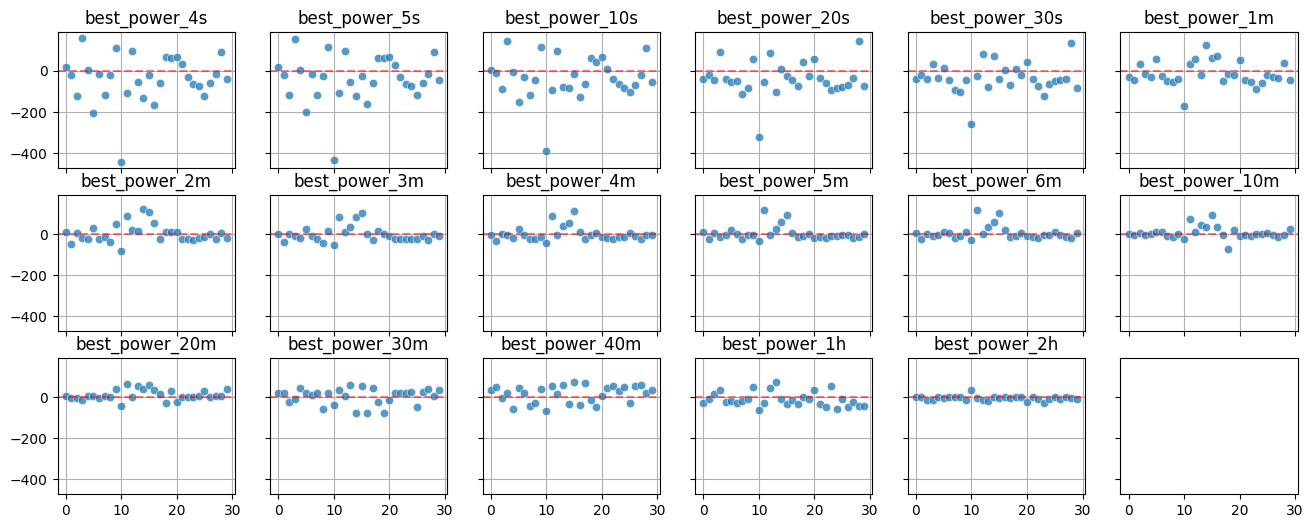

In [15]:
plot_residuals(y_pred, y_val, target_cols)

### Sanity Check: 4s Effort Model

In [16]:
outputs = timeseries_cross_validated_regression(X_train, y_train[:,0], linreg,n_subseries_splits=10)

For metric "R^2", the latest value (final subseries) = 0.4152137003053462
For metric "RMSLE", the latest value (final subseries) = 0.22225557009173738


In [17]:
final_r2 = outputs['raw_final_r2']
final_rmsle = outputs['raw_final_rmsle']

In [18]:
print(final_r2)

[0.4152137]


In [19]:
print(final_rmsle)

[0.22225557]


In [40]:
df_coeficients = pd.DataFrame(linreg.fit(X_train, y_train).coef_, columns=feature_cols, index=target_cols)

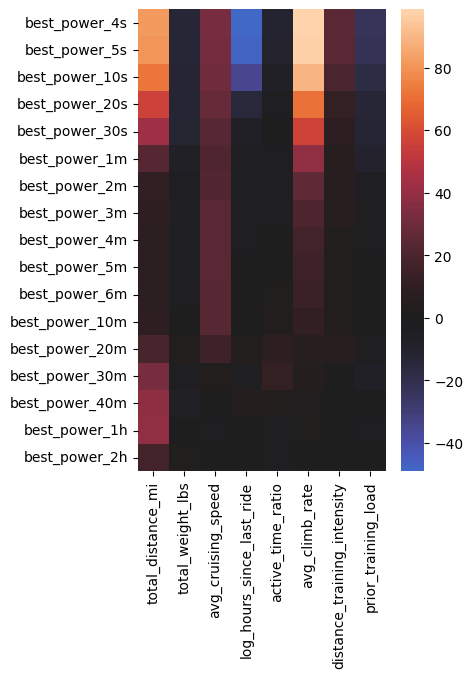

In [41]:
_ = plt.figure(figsize=(4,6))
_ = sns.heatmap(df_coeficients.replace(to_replace={0:np.nan}), center=0)

# 1b. Baseline Models: $y_k = B_kx$ MultiOutput Regression

For each output target variable (17 of them), an independent model is created using the `MultiOutputRegressor` meta-estimator

ref: https://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_regression_multioutput.html

In [20]:
from sklearn.multioutput import MultiOutputRegressor

In [21]:
mo_linreg = MultiOutputRegressor(LinearRegression())

In [22]:
outputs = timeseries_cross_validated_regression(X_train, y_train, mo_linreg, n_subseries_splits=10)

For metric "R^2", the latest value (final subseries) = 0.38669458416810837
For metric "RMSLE", the latest value (final subseries) = 0.7020580801205452


In [23]:
final_r2 = outputs['raw_final_r2']
final_rmsle = outputs['raw_final_rmsle']

In [24]:
print(final_r2)

[0.4152137  0.42005859 0.44776513 0.38018739 0.23693144 0.40409512
 0.45159128 0.35952927 0.31296219 0.22499696 0.20633455 0.44100117
 0.40819685 0.44258042 0.34732681 0.45616734 0.61886972]


In [25]:
print(final_rmsle)

[0.22225557 0.22063923 0.21468675 0.22257927 0.22314163 0.20395144
 0.17473641 0.1730554  0.16738854 0.1757151  0.18733261 0.80832363
 0.65323987 1.83285113 1.89367614 2.75589102 1.80552362]


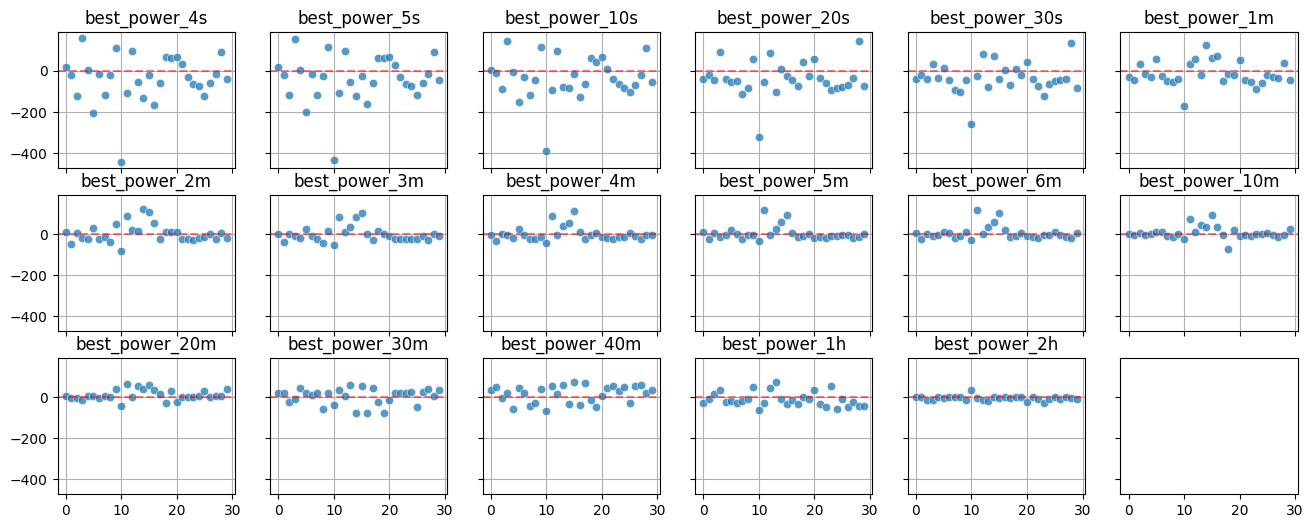

In [26]:
plot_residuals(outputs['predictions'][-1], outputs['actuals'][-1], target_cols)

# 1c. Baseline Models: RegressorChain Regression
This strategy will take advantage of the correlations between target variables

In [27]:
from sklearn.multioutput import RegressorChain

In [28]:
regchain_linreg_ordered = RegressorChain(LinearRegression(), order=range(len(target_cols)), verbose=False)
regchain_linreg_random = RegressorChain(LinearRegression(), order='random', random_state=42)

### Column Chain Ordered by Effort Duration (4s-->2h)

In [29]:
outputs = timeseries_cross_validated_regression(X_train, y_train, regchain_linreg_ordered, n_subseries_splits=10)

For metric "R^2", the latest value (final subseries) = 0.3866945841681033
For metric "RMSLE", the latest value (final subseries) = 0.7020580801205457


In [30]:
final_r2 = outputs['raw_final_r2']
final_rmsle = outputs['raw_final_rmsle']

In [31]:
print(final_r2)

[0.4152137  0.42005859 0.44776513 0.38018739 0.23693144 0.40409512
 0.45159128 0.35952927 0.31296219 0.22499696 0.20633455 0.44100117
 0.40819685 0.44258042 0.34732681 0.45616734 0.61886972]


In [32]:
print(final_rmsle)

[0.22225557 0.22063923 0.21468675 0.22257927 0.22314163 0.20395144
 0.17473641 0.1730554  0.16738854 0.1757151  0.18733261 0.80832363
 0.65323987 1.83285113 1.89367614 2.75589102 1.80552362]


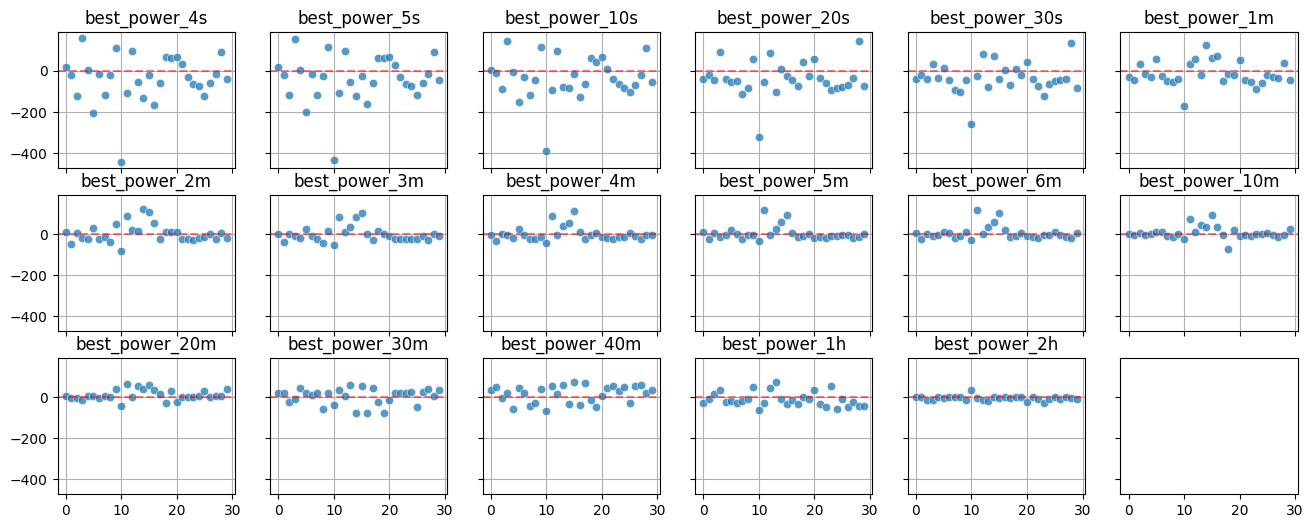

In [33]:
plot_residuals(outputs['predictions'][-1], outputs['actuals'][-1], target_cols)

### Random Column Chain Order

In [34]:
outputs = timeseries_cross_validated_regression(X_train, y_train, regchain_linreg_random, n_subseries_splits=10)

For metric "R^2", the latest value (final subseries) = 0.38669458416810293
For metric "RMSLE", the latest value (final subseries) = 0.7020580801205462


In [35]:
final_r2 = outputs['raw_final_r2']
final_rmsle = outputs['raw_final_rmsle']

In [36]:
print(final_r2)

[0.4152137  0.42005859 0.44776513 0.38018739 0.23693144 0.40409512
 0.45159128 0.35952927 0.31296219 0.22499696 0.20633455 0.44100117
 0.40819685 0.44258042 0.34732681 0.45616734 0.61886972]


In [37]:
print(final_rmsle)

[0.22225557 0.22063923 0.21468675 0.22257927 0.22314163 0.20395144
 0.17473641 0.1730554  0.16738854 0.1757151  0.18733261 0.80832363
 0.65323987 1.83285113 1.89367614 2.75589102 1.80552362]


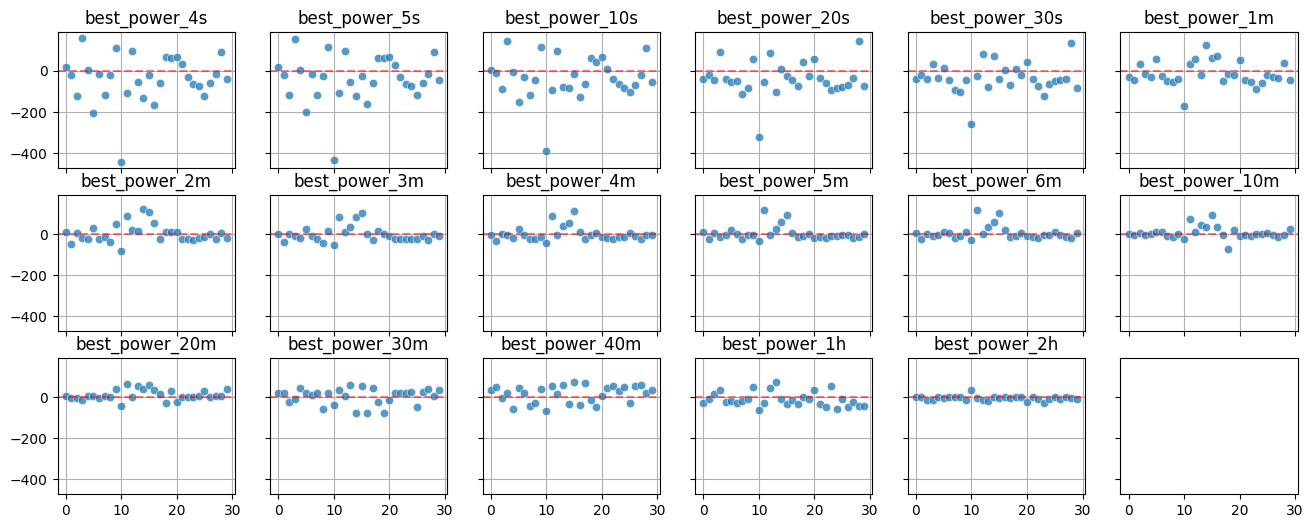

In [38]:
plot_residuals(outputs['predictions'][-1], outputs['actuals'][-1], target_cols)

# 1d. Baseline Model: Split-Target Parallel Models Approach

In [39]:
def parallel_timeseries_cross_validated_regression(X, y, columnn_regressor_map:dict[str, dict[str,Any]],
                                                    n_subseries_splits=10, verbose:bool=True):
    tss = TimeSeriesSplit(n_splits=n_subseries_splits)

    overall_r2_scores = []
    overall_rmsle_scores = []
    predictions = {regressor:[] for regressor in columnn_regressor_map.keys()}
    actuals = {regressor:[] for regressor in columnn_regressor_map.keys()}
    for regressor_name in columnn_regressor_map.keys():
        regressor = columnn_regressor_map[regressor_name]['estimator']
        relevant_column_indices = columnn_regressor_map[regressor_name]['estimator']
        for train_index, val_index in tss.split(X, y[:,relevant_column_indices]):
            X_tr, X_val = X[train_index], X[val_index]
            y_tr, y_val = y[train_index], y[val_index]
            
            regressor.fit(X_tr, y_tr)